In [ ]:
#recommend mounting to drive to save train, val, test splits, for easy recovery later
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture 
import numpy as np
import pandas as pd
import nltk
nltk.download("wordnet")
from nltk.corpus import wordnet
import re
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

##Dataset, data analysis and manipulation

In [ ]:
#import empatheticPersonas dataset
data = pd.read_csv('drive/MyDrive/empatheticPersonas.csv') #put dataset in Drive root folder or change path

In [ ]:
#extract sad patient response columns
sad_df = data[['Sad - Patient response 1', 'Sad - Patient response 2', 'Sad - Patient response 3']]

In [ ]:
#extract each column as series
sad1 = sad_df['Sad - Patient response 1']
sad2 = sad_df['Sad - Patient response 2']
sad3 = sad_df['Sad - Patient response 3']

In [ ]:
#concatenate series
sad12 = sad1.append(sad2)
sad = sad12.append(sad3)

In [ ]:
#convert result to dataframe and drop rows with null values
sad_df = sad.to_frame()
sad_df = sad_df.dropna()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [ ]:
#insert class column with all values set to sadness and rename columns
sad_df.insert(1, 'class', 'sadness')
sad_df.columns = ['text', 'class']

In [ ]:
#extract angry patient response columns
angry_df = data[['Angry - Patient response 1', 'Angry - Patient response 2', 'Angry - Patient response 3']]

In [ ]:
#extract each angry column as series
angry1 = angry_df['Angry - Patient response 1']
angry2 = angry_df['Angry - Patient response 2']
angry3 = angry_df['Angry - Patient response 3']

In [ ]:
#concatenate series
angry12 = angry1.append(angry2)
angry = angry12.append(angry3)

In [ ]:
#convert angry series to dataframe and drop rows with null values
angry_df = angry.to_frame()
angry_df = angry_df.dropna()

In [ ]:
#insert class column with all values set to anger and rename columns
angry_df.insert(1, 'class', 'anger')
angry_df.columns = ['text', 'class']

In [ ]:
#extract anxious/fearful patient response columns
fearful_df = data[['Anxious - Patient response 1', 'Anxious - Patient response 2', 'Anxious - Patient response 3']]

In [ ]:
#extract each fearful column as series
fearful1 = fearful_df['Anxious - Patient response 1']
fearful2 = fearful_df['Anxious - Patient response 2']
fearful3 = fearful_df['Anxious - Patient response 3']

In [ ]:
#concatenate series
fearful12 = fearful1.append(fearful2)
fearful = fearful12.append(fearful3)

In [ ]:
#convert fearful series to dataframe and drop rows with null values
fearful_df = fearful.to_frame()
fearful_df = fearful_df.dropna()

In [ ]:
#insert class column with all values set to fear and rename columns
fearful_df.insert(1, 'class', 'fear')
fearful_df.columns = ['text', 'class']

In [ ]:
#extract happy patient response columns
happy_df = data[['Happy - Patient response 1', 'Happy - Patient response 2', 'Happy - Patient response 3']]

In [ ]:
#extract each happy column as series
happy1 = happy_df['Happy - Patient response 1']
happy2 = happy_df['Happy - Patient response 2']
happy3 = happy_df['Happy - Patient response 3']

In [ ]:
#concatenate series
happy12 = happy1.append(happy2)
happy = happy12.append(happy3)

In [ ]:
#convert happy series to dataframe and drop rows with null values
happy_df = happy.to_frame()
happy_df = happy_df.dropna()

In [ ]:
#insert class column with all values set to joy and rename columns
happy_df.insert(1, 'class', 'joy')
happy_df.columns = ['text', 'class']

In [ ]:
#concatenate sad, angry, fearful and happy dataframes into one, shuffle and reset indices
df = pd.concat([sad_df, angry_df, fearful_df, happy_df])
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
#we obtain a dataframe with 1181 rows, divided into four classes
len(df)

1181

In [ ]:
#The classes are well balanced
df.groupby('class').size()

class
anger      297
fear       284
joy        300
sadness    300
dtype: int64

In [ ]:
#remove punctuation from responses in text column and make everything lower case
df['text'] = df['text'].str.replace('[^\w\s]','')
df['text'] = df['text'].str.lower()

In [ ]:
df = df.rename(columns={'class': 'emotions'})

In [ ]:
#make directory in drive to save dataset splits (change path if desired)
!mkdir -p 'drive/MyDrive/emotion_data'

In [ ]:
#generate the text files for train, val, and test datasets in 80:10:10 proportion

#change paths if desired
train_path = "drive/MyDrive/emotion_data/my_train.txt" 
test_path = "drive/MyDrive/emotion_data/my_test.txt"
val_path = "drive/MyDrive/emotion_data/my_val.txt"


from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(df.text.to_numpy(), 
                                                                    df.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(val_path, sep=";",header=False, index=False)
test_dataset.to_csv(test_path, sep=";",header=False, index=False)

In [ ]:
#sanity check
train_dataset.count()

text     944
class    944
dtype: int64

##Baseline

We use as baseline the rule-based method which uses lists of 'for' and 'against' keywords to label emotions. This is the method which was implemented by Imperial student Ali Ghachem in the previous version of SATbot.

The 'for' and 'against' lists contain synonyms and antonyms, respectively, of the target emotions, augmented using wordnet. For each emotion we count the number of 'for' words and the number of 'against' words, then subtract one from the other. The result is the score for that emotion. The higher score wins, and in case of ties the earliest emotion is chosen (the order being 'happy/content', 'sad', 'angry', 'anxious/scared').

In [ ]:
#We can test this method directly on our test set

test_path = "drive/MyDrive/emotion_data/my_test.txt" #change path if necessary to match previous changes
test_dataset = pd.read_csv(test_path, sep=';', header=None)
test_dataset.columns = ['text', 'class']

#define the functions we need (these are adapted from Ali Ghachem's original code)

def calculate_emotion_scores(user_response):

        user_input = user_response.lower()
        tokenised_input = re.findall(r"[\w']+", user_input)

        scores = [
            detect_happy(tokenised_input),
            detect_sad(tokenised_input),
            detect_angry(tokenised_input),
            detect_anxious(tokenised_input)
        ]

        return scores


def detect_happy(tokenised_input):

        starting_for_keywords = [
            "good",
            "happy",
            "fine",
            "well",
            "delighted",
            "great",
            "positive",
            "decent",
            "content",
            "relaxed",
            "ok",
            "joyful"
        ]
        starting_against_keywords = [
            "sad",
            "unhappy",
            "angry",
            "scared",
            "anxious",
            "upset"
        ]

        #keywords for detecting and not detecting the emotion, respectively
        for_keywords, against_keywords = extract_for_and_against_keywords(
            starting_for_keywords, starting_against_keywords
        )

        return calculate_score(tokenised_input, for_keywords, against_keywords)


def detect_sad(tokenised_input):
        starting_for_keywords = ["bad", "sad", "unhappy", "depressed"]
        starting_against_keywords = [
            "neutral",
            "angry",
            "scared",
            "anxious",
            "happy",
            "worried",
            "not",
        ]

        # Keywords for detecting and not detecting the behaviour, respectively
        for_keywords, against_keywords = extract_for_and_against_keywords(
            starting_for_keywords, starting_against_keywords
        )

        return calculate_score(tokenised_input, for_keywords, against_keywords)


def detect_angry(tokenised_input):
        starting_for_keywords = ["angry", "furious", "rage", "enraged"]
        starting_against_keywords = [
            "neutral",
            "upset",
            "depressed",
            "scared",
            "anxious",
            "worried",
            "happy",
        ]

        # Keywords for detecting and not detecting the behaviour, respectively
        for_keywords, against_keywords = extract_for_and_against_keywords(
            starting_for_keywords, starting_against_keywords
        )

        return calculate_score(tokenised_input, for_keywords, against_keywords)


def detect_anxious(tokenised_input):
        starting_for_keywords = ["scared", "afraid", "anxious", "worried", "fearful"]
        starting_against_keywords = ["neutral", "upset", "depressed", "happy", "angry", "furious"]

        # Keywords for detecting and not detecting the behaviour, respectively
        for_keywords, against_keywords = extract_for_and_against_keywords(
            starting_for_keywords, starting_against_keywords
        )

        return calculate_score(tokenised_input, for_keywords, against_keywords)


def extract_for_and_against_keywords(
        starting_for_keywords, starting_against_keywords
    ):
        for_keywords = starting_for_keywords
        against_keywords = starting_against_keywords
        for i in range(len(starting_for_keywords)):
            word = starting_for_keywords[i]
            for syn in wordnet.synsets(word):
                for lemma in syn.lemmas():
                    # Adds lemmas to for_keywords
                    for_keywords.append(lemma.name())
                    if lemma.antonyms():
                        for antonym in lemma.antonyms():
                            against_keywords.append(antonym.name())

        return set(for_keywords), set(against_keywords)


def calculate_score(user_input, for_keywords, against_keywords):

        score = 0
        for word in user_input:
            if word in for_keywords:
                score += 1

            elif word in against_keywords:
                score -= 1

        return score


In [ ]:
def get_emotion_rulebased(text):

  emotion_scores = calculate_emotion_scores(text)
  max_pos = np.argmax(emotion_scores)
  emotion = ''

  if max_pos == 0:
    emotion = 'joy'
  elif max_pos == 1:
    emotion = 'sadness'
  elif max_pos == 2:
    emotion = 'anger'
  else:
    emotion = 'fear'

  return emotion

In [ ]:
#quick sanity check before testing on the whole test set
text="I feel like nothing matters anymore" #we try a sentence with no sentiment word to trick the model, but the sentiment is clear (sadness)
get_emotion_rulebased(text)

'joy'

In [ ]:
#now we test this on our test set (the same we will use to test the finetuned transformer model)

test_dataset['pred'] = ''

for index, row in test_dataset.iterrows():
  test_dataset.at[index, 'pred'] = get_emotion_rulebased(row['text'])

In [ ]:
#check accuracy on the held-out test set, we get ~63% - this is our baseline accuracy
outputs = test_dataset['pred'].to_numpy().tolist()
targets = test_dataset['class'].to_numpy().tolist()

metrics.accuracy_score(targets, outputs).round(4)

0.6303

In [ ]:
#check all metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

       anger     1.0000    0.3333    0.5000        27
        fear     0.8148    0.6875    0.7458        32
         joy     0.4032    1.0000    0.5747        25
     sadness     0.9048    0.5429    0.6786        35

    accuracy                         0.6303       119
   macro avg     0.7807    0.6409    0.6248       119
weighted avg     0.7968    0.6303    0.6343       119



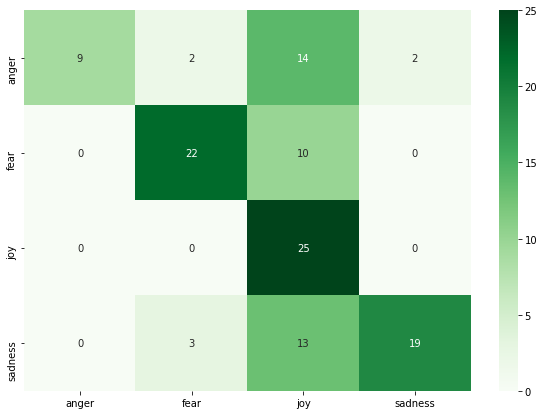

In [ ]:
#plot confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(targets, outputs)

df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "sadness"], columns = ["anger", "fear", "joy", "sadness"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

Note that 'joy' gets predicted quite a lot. When the model finds no keyword and all the emotion values are zero, it always chooses the first emotion in the list, which is joy.